In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [369]:
def join_csv_files(data_path, match):
  """Joins all CSV files in a given directory into a single DataFrame.

  Args:
    data_path: The path to the directory containing the CSV files.
    regex: A regular expression to match the CSV files.

  Returns:
    A pandas DataFrame containing the combined data.
  """
  data_frames = []
  first_file = True

  for filename in os.listdir(data_path):
    if match in filename:
      file_path = os.path.join(data_path, filename)
      df = pd.read_csv(file_path)

      if first_file:
        data_frames.append(df)
        first_file = False
      else:
        data_frames.append(df.iloc[1:])  # Skip the header in subsequent files

  if len(data_frames) > 0:
    return pd.concat(data_frames, ignore_index=True)
  else:
    print("No CSV files found in the directory.")
    return None
  

In [370]:
# Read the data from the CSV file
data_path = "../out/data/"
output_path = "../docs/res/plots/"

df_seq_raw = join_csv_files(data_path, "SEQUENTIAL").rename(columns={"CPUs/Threads" : "Processes"})
df_mpi_raw = join_csv_files(data_path, "MPI").rename(columns={"CPUs" : "Processes"})
df_omp_raw = join_csv_files(data_path, "OMP").rename(columns={"Threads" : "Processes"})


In [371]:
def plot_barplot_mpi_impl(df, title, n_procs):
    df_by_thread= df[df["Processes"] == n_procs]
    df_by_thread = df_by_thread[df_by_thread["Matrix Size"] > 0]
    mpi_scatter = df_by_thread[(df_by_thread["Implementation"] == "MPI") & (df_by_thread["MPI Implementation"] == "SCATTER")]
    mpi_broadcast = df_by_thread[(df_by_thread["Implementation"] == "MPI") & (df_by_thread["MPI Implementation"] == "BROADCAST")]

    bar_width = 2
    group_spacing = 2
    x_values = np.arange(len(df_by_thread["Matrix Size"].unique())) * (1.5 * bar_width + group_spacing)
    
    plt.figure(figsize=(12, 6))
    # use row index as x values
    plt.xticks(x_values, df_by_thread["Matrix Size"].unique())
    plt.xlabel("Matrix Size")
    plt.ylabel("Execution Time (us)")
    plt.yscale("log")
    plt.title(f"Execution Time per Matrix Size - {title}")
    plt.bar(x_values - (bar_width / 2), mpi_scatter["Execution Time"] * 1e6, bar_width, label=("MPI_Scatter"))
    plt.bar(x_values + (bar_width / 2), mpi_broadcast["Execution Time"] * 1e6, bar_width, label=("MPI_Broadcast"))
    plt.legend()
    plt.grid(True, which='both', axis='y', ls="--", linewidth=0.5, zorder=0)
    plt.savefig(f"{output_path}/exec_time_mpi_scatter_broadcast_{n_procs}.png")
    # plt.show()

In [372]:
df_mpi_mean = df_mpi_raw.groupby(["Matrix Size", "Processes", "Function", "Implementation", "MPI Implementation"]).mean().reset_index()



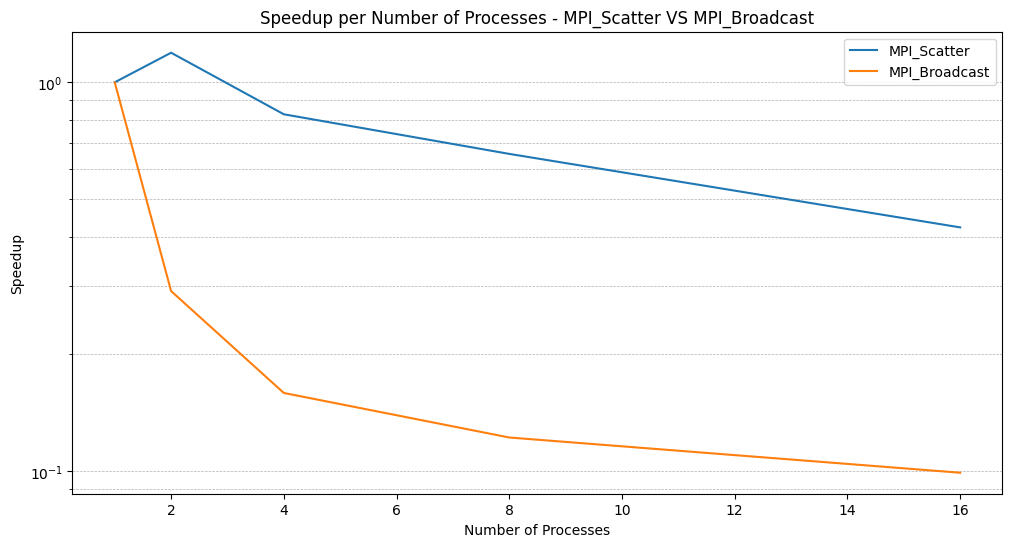

In [373]:
# function that plots speedup of different mpi implementations, one with each line
def plot_mpi_impl_speedup(df, title):
    df = df[df["Matrix Size"] == 16]
    mpi_scatter = df[(df["Implementation"] == "MPI") & (df["MPI Implementation"] == "SCATTER")]
    mpi_broadcast = df[(df["Implementation"] == "MPI") & (df["MPI Implementation"] == "BROADCAST")]

    plt.figure(figsize=(12, 6))
    
    scatter_speedup = mpi_scatter["Execution Time"].iloc[0] / mpi_scatter["Execution Time"]
    broadcast_speedup = mpi_broadcast["Execution Time"].iloc[0] / mpi_broadcast["Execution Time"]
    
    plt.plot(mpi_scatter["Processes"], scatter_speedup, label="MPI_Scatter")
    plt.plot(mpi_broadcast["Processes"], broadcast_speedup, label="MPI_Broadcast")
    
    plt.xlabel("Number of Processes")
    plt.ylabel("Speedup")
    plt.yscale("log")
    plt.title(f"Speedup per Number of Processes - {title}")
    plt.legend()
    plt.grid(True, which='both', axis='y', ls="--", linewidth=0.5, zorder=0)
    plt.savefig(f"{output_path}/speedup_mpi_scatter_broadcast.png")
    # plt.show()

plot_mpi_impl_speedup(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast")

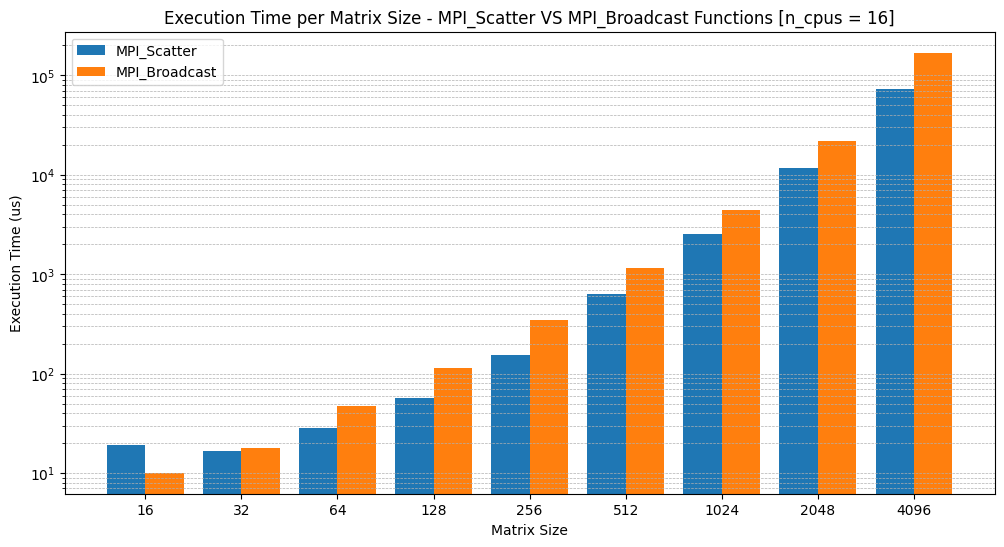

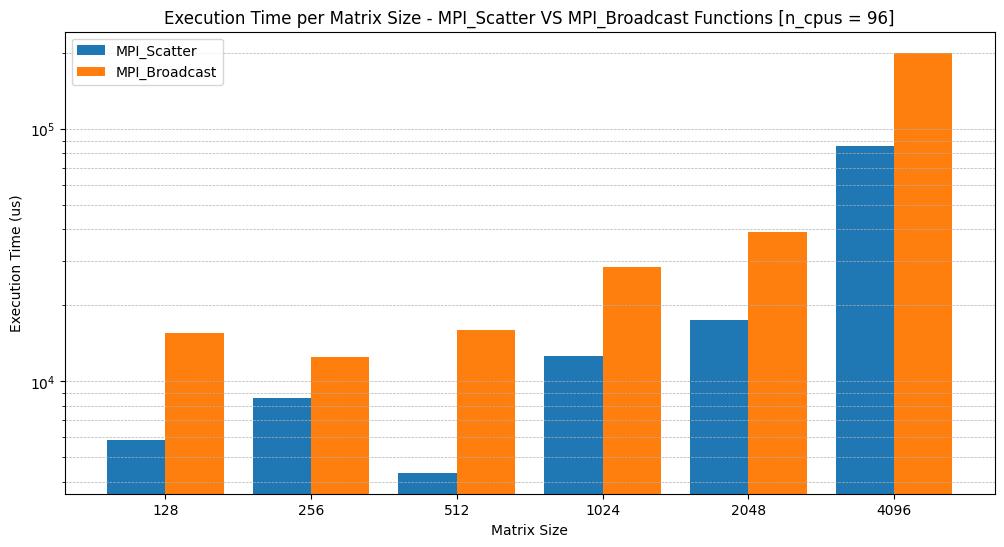

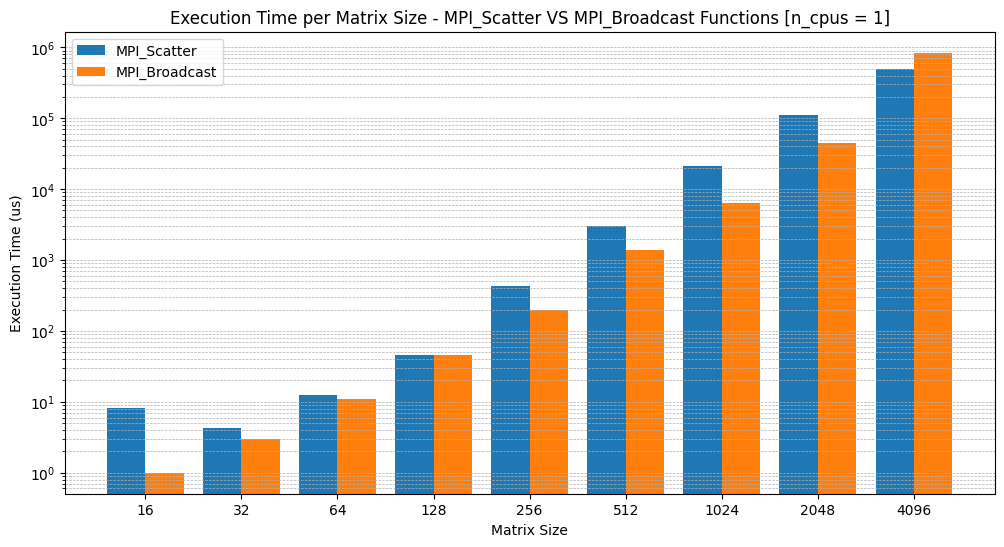

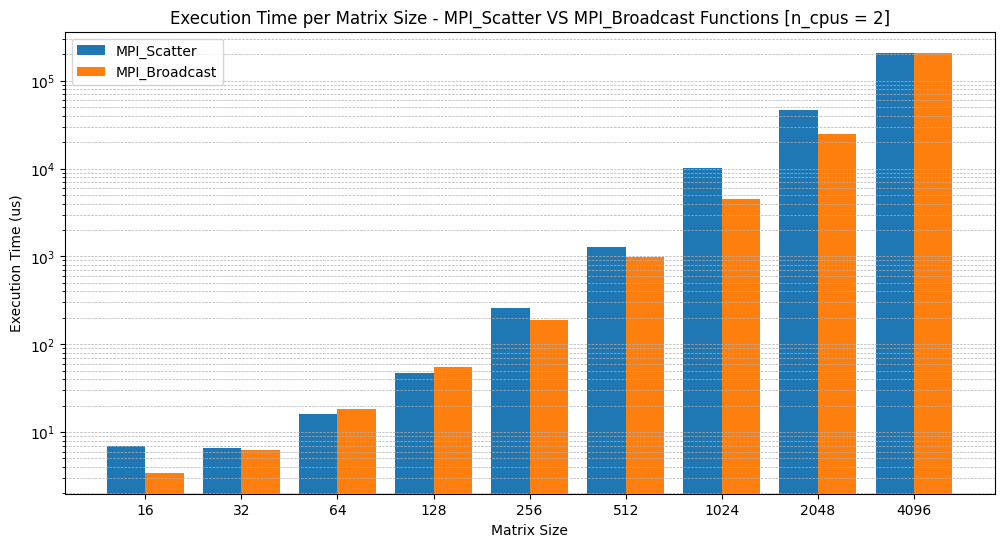

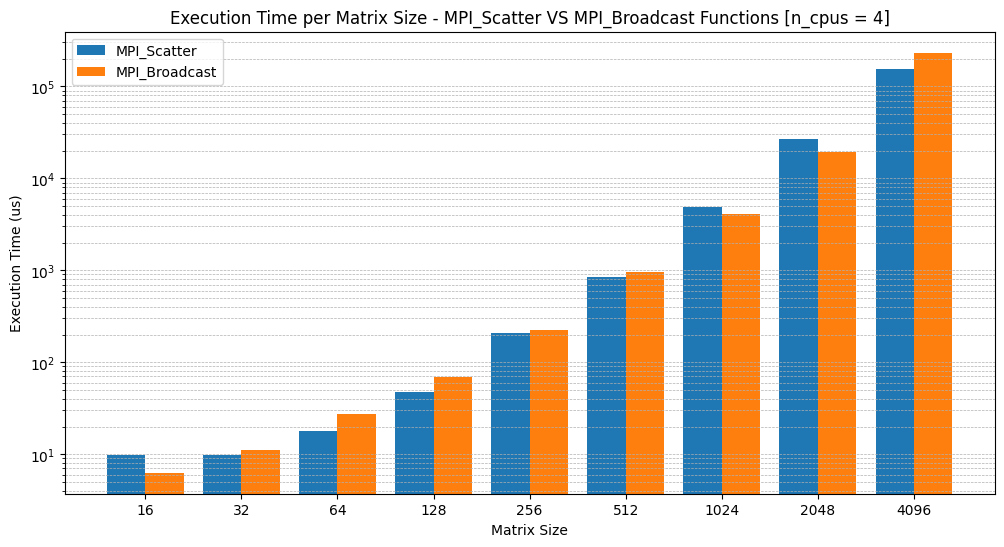

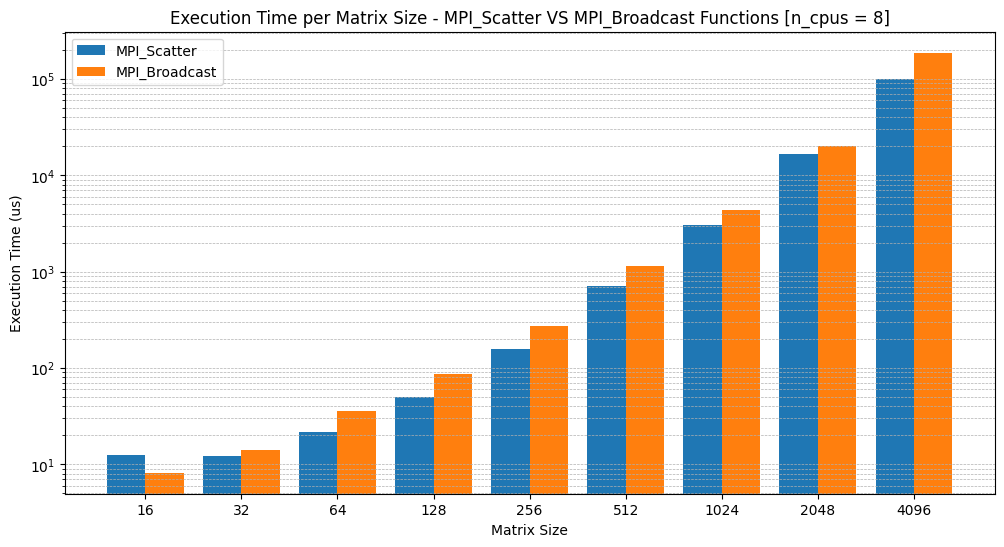

In [374]:

plot_barplot_mpi_impl(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast Functions [n_cpus = 16]", 16)
plot_barplot_mpi_impl(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast Functions [n_cpus = 96]", 96)
plot_barplot_mpi_impl(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast Functions [n_cpus = 1]", 1)
plot_barplot_mpi_impl(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast Functions [n_cpus = 2]", 2)
plot_barplot_mpi_impl(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast Functions [n_cpus = 4]", 4)
plot_barplot_mpi_impl(df_mpi_mean, "MPI_Scatter VS MPI_Broadcast Functions [n_cpus = 8]", 8)

In [375]:
df_mpi_best = df_mpi_raw.loc[df_mpi_raw["MPI Implementation"].isin(['SCATTER', 'REDUCE'])]

df_raw = pd.concat([df_seq_raw, df_mpi_best, df_omp_raw])

In [376]:
def exec_time(df):
    """Calculates the mean execution time for each group of rows with the same 
    Matrix Size, Threads, Function, and Implementation.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.

    Returns:
        pandas.DataFrame: A DataFrame with the calculated mean execution times.
    """
    
    # Calculate average execution time and standard deviation for each combination of Matrix Size, Function, and Implementation
    df_grouped = df.groupby(["Matrix Size", "Processes", "Function", "Implementation"])
    df_mean = df_grouped.mean().reset_index()
    # df_std_dev = df_grouped.std().reset_index()

    # print(df_mean)

    return df_mean

In [377]:
df = exec_time(df_raw)

C:\Users\chiar\AppData\Local\Temp\ipykernel_29432\176066166.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_grouped.mean().reset_index()


In [378]:
def calculate_metrics(group):
    """
    Calculate speedup and efficiency for a given group of execution times.

    Parameters:
    group (pd.DataFrame): DataFrame containing execution times and implementation details.

    Returns:
    pd.Series: Series containing speedup and efficiency.
    """

    seq_time = group[group["Implementation"] == "SEQUENTIAL"]["Execution Time"].values[0]
    parallel_time = group[group["Implementation"].isin(["OMP", "MPI"])]["Execution Time"].values[0]
    n_threads = group["Processes"].values[0]

    speedup = seq_time / parallel_time
    efficiency = speedup / n_threads

    return pd.Series({"Speedup": speedup, "Efficiency": efficiency})

In [379]:
def calculate_speedup_efficiency(df, implementation):
    """Calculates the speedup and efficiency of the OpenMP implementation relative to the sequential implementation.

    Args:
        df: A pandas DataFrame containing the execution times for sequential and OpenMP implementations.

    Returns:
        A pandas DataFrame with columns for matrix size, number of threads, speedup, and efficiency.
    """

    df_filtered = df[df["Implementation"].isin(["SEQUENTIAL", implementation])]
    df_grouped = df_filtered.groupby(["Matrix Size", "Processes", "Function"])

    result_df = df_grouped.apply(calculate_metrics)
    
    return result_df.reset_index()

In [380]:
def plot_speedup_efficiency(df_speedup_efficiency, impl):
    # Plot speedup vs. number of Processes for different matrix sizes and implementations
    for func in df_speedup_efficiency["Function"].unique():
        plt.figure(figsize=(12, 6))
        for size in df_speedup_efficiency["Matrix Size"].unique():
            data = df_speedup_efficiency[(df_speedup_efficiency["Matrix Size"] == size) & (df_speedup_efficiency["Function"] == func)]
            plt.plot(data["Processes"], data["Speedup"], label=f"Size {size}")

        plt.xticks([1, 2, 4, 8, 16, 32, 64, 96])
        plt.xlabel("Number of Processes")
        plt.ylabel("Speedup")
        plt.title(f"Speedup per Number of Processes - {func} {impl}")
        plt.legend()
        plt.grid(True)
        # plt.show()
        plt.savefig(f"{output_path}/speedup_{func}_{impl}.png")

    # Plot efficiency vs. number of Processes for different matrix sizes and implementations
    for func in df_speedup_efficiency["Function"].unique():
        plt.figure(figsize=(12, 6))
        for size in df_speedup_efficiency["Matrix Size"].unique():
            data = df_speedup_efficiency[(df_speedup_efficiency["Matrix Size"] == size) & (df_speedup_efficiency["Function"] == func)]
            plt.plot(data["Processes"], data["Efficiency"], label=f"Size {size}")

        plt.xticks([1, 2, 4, 8, 16, 32, 64, 96])
        plt.xlabel("Number of Processes")
        plt.ylabel("Efficiency")
        plt.title(f"Efficiency per Number of Processes - {func} {impl}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_path}/efficiency_{func}_{impl}.png")
        # plt.show()


In [381]:
def plot_exec_time_parallel(df, implementation):
    parallel = df[df["Implementation"] == implementation]

    for func in parallel["Function"].unique():
        plt.figure(figsize=(12, 6))

        for num_processes in parallel["Processes"].unique():
            data = parallel[parallel["Processes"] == num_processes]
            plt.plot(data["Matrix Size"], data["Execution Time"] * 1e6, label=f"{num_processes} Processes")

        plt.xlabel("Matrix Size")
        plt.ylabel("Execution Time (us)")
        plt.yscale("log")
        plt.title(f"Execution Time per Matrix Size - {func} {implementation}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_path}/exec_time_{func}_{implementation}.png")
        # plt.show()

def plot_barplot_all(df, title):
    df_by_thread = df[df["Processes"] == 16]
    df_by_thread = df_by_thread[df_by_thread["Matrix Size"] > 0]
    mpi = df_by_thread[(df_by_thread["Implementation"] == "MPI")]
    omp = df_by_thread[(df_by_thread["Implementation"] == "OMP")]
    seq = df_by_thread[(df_by_thread["Implementation"] == "SEQUENTIAL")]

    bar_width = 2
    group_spacing = 2
    x_values = np.arange(len(df_by_thread["Matrix Size"].unique())) * (3 * bar_width + group_spacing)
    
    plt.figure(figsize=(12, 6))
    # use row index as x values
    plt.xticks(x_values, mpi["Matrix Size"])
    plt.xlabel("Matrix Size")
    plt.ylabel("Execution Time (us)")
    plt.yscale("log")
    plt.title(f"Execution Time per Matrix Size - {title}")
    plt.bar(x_values - bar_width, mpi["Execution Time"] * 1e6, bar_width, label=("MPI"))
    plt.bar(x_values, seq["Execution Time"] * 1e6, bar_width, label=("SEQUENTIAL"))
    plt.bar(x_values + bar_width, omp["Execution Time"] * 1e6, bar_width, label=("OMP"))
    plt.legend()
    plt.grid(True, which='both', axis='y', ls="--", linewidth=0.5, zorder=0)
    plt.savefig(f"{output_path}/exec_time_{title}.png")
    # plt.show()

def plot_execution_time(df):
    df_symmetry = df[df["Function"] == "SYMMETRY"]
    df_transposition = df[df["Function"] == "TRANSPOSITION"]

    plot_exec_time_parallel(df_symmetry, "MPI")
    plot_exec_time_parallel(df_transposition, "MPI")
    plot_barplot_all(df_symmetry, "SYMMETRY")
    plot_barplot_all(df_transposition, "TRANSPOSITION")
    # plot_exec_time_parallel(df_symmetry, "OMP")
    # plot_exec_time_parallel(df_transposition, "OMP")

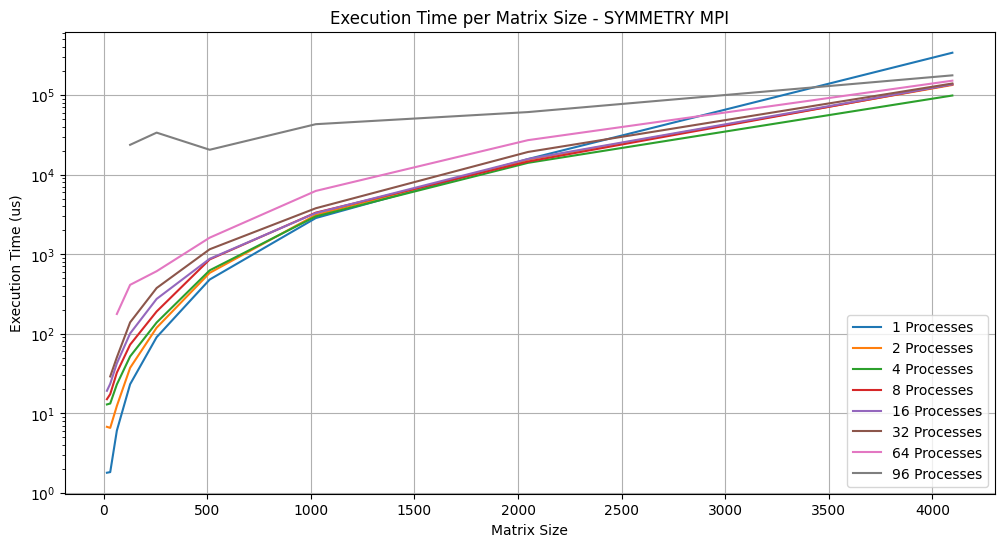

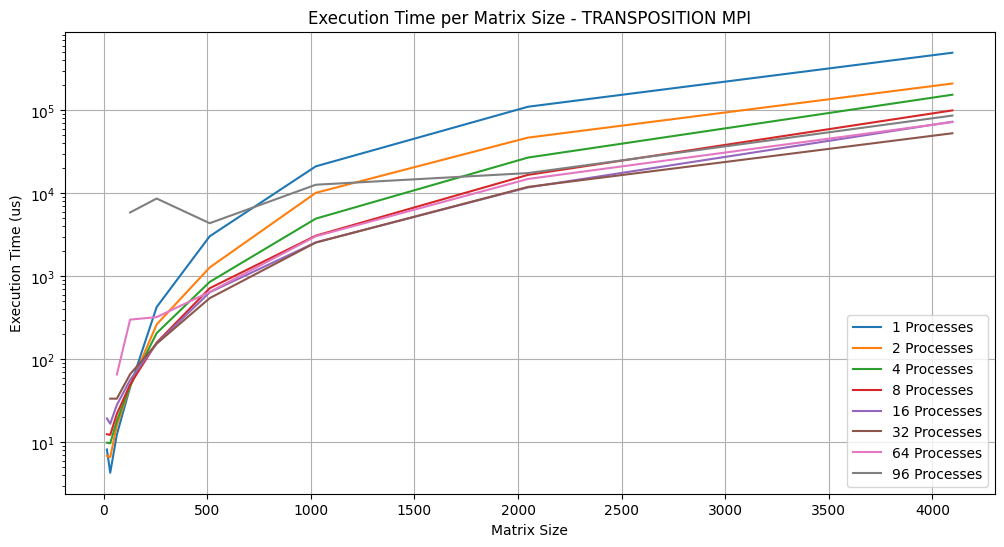

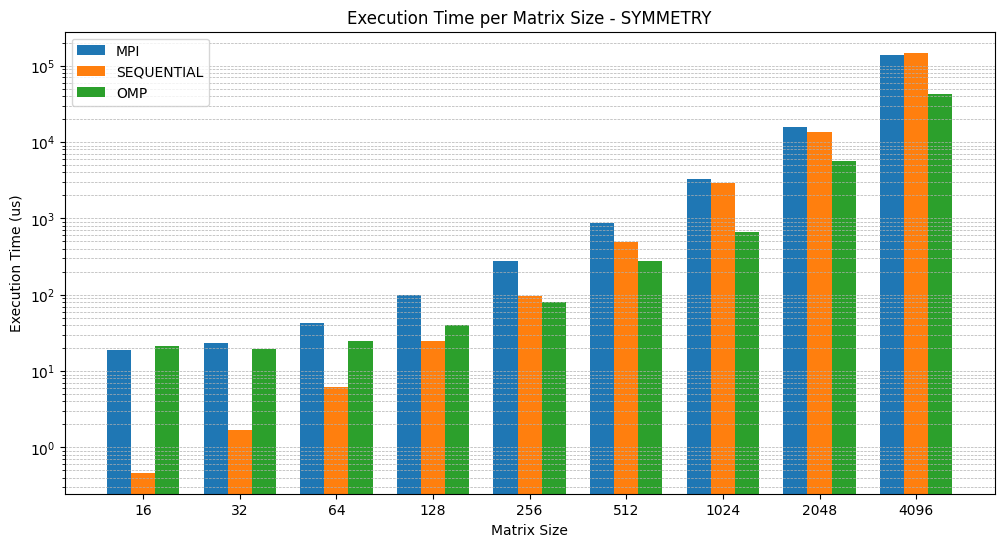

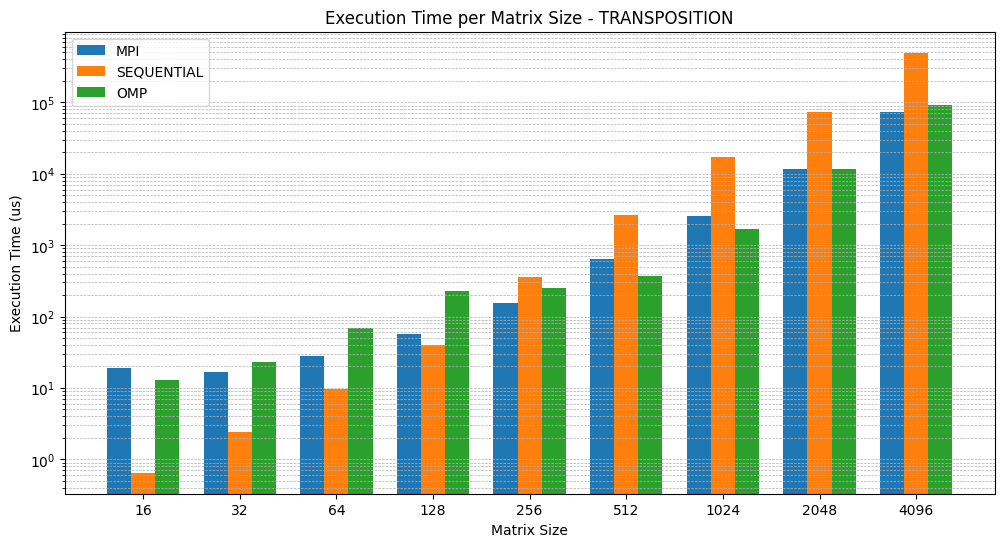

In [382]:
plot_execution_time(df)

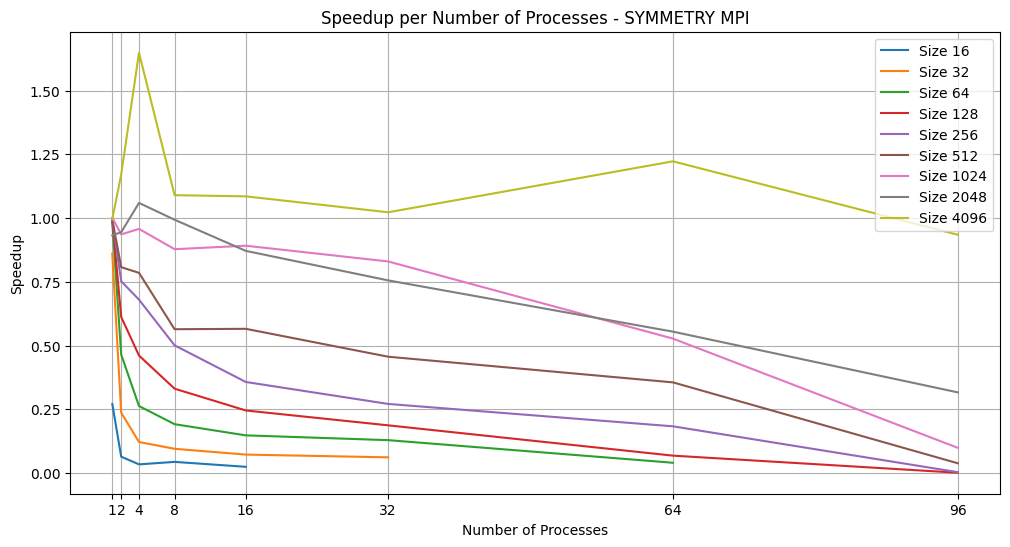

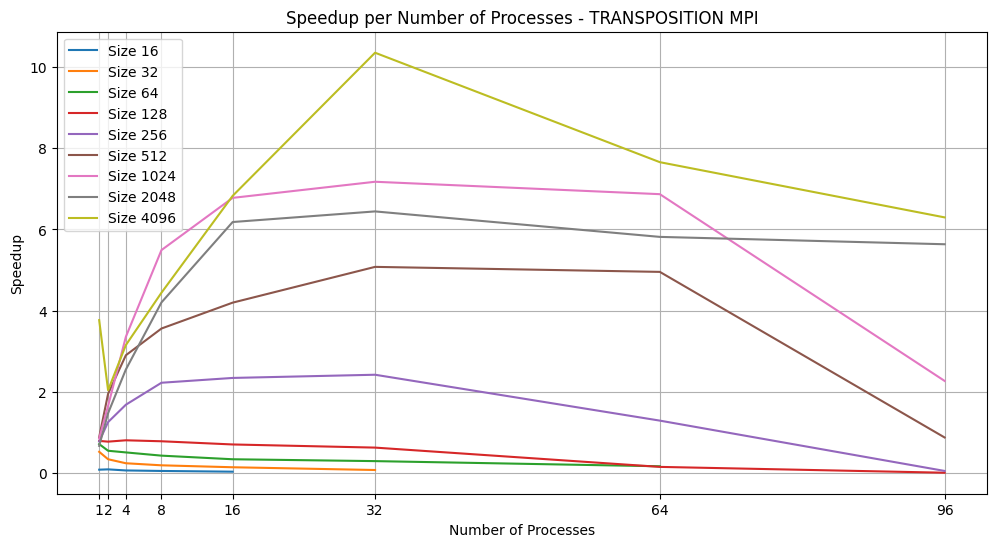

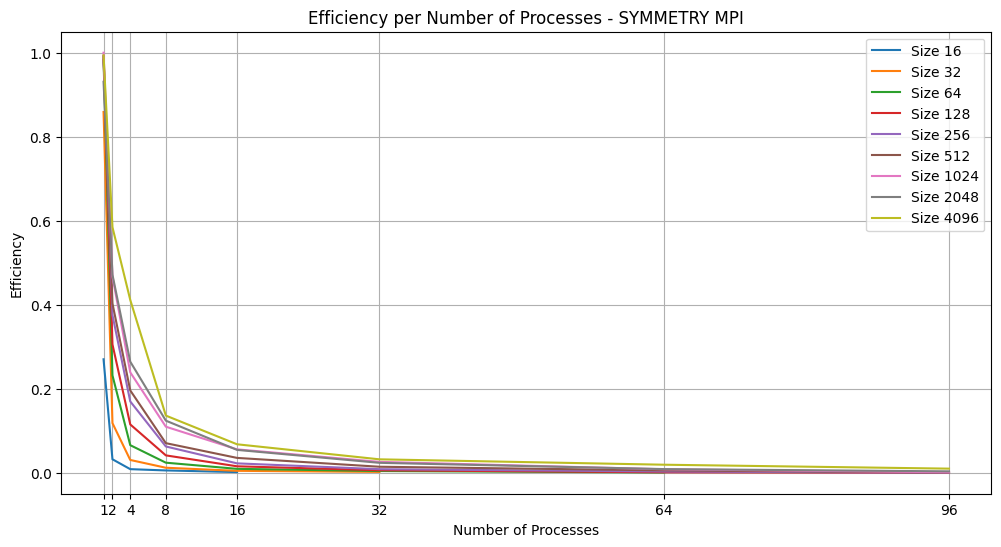

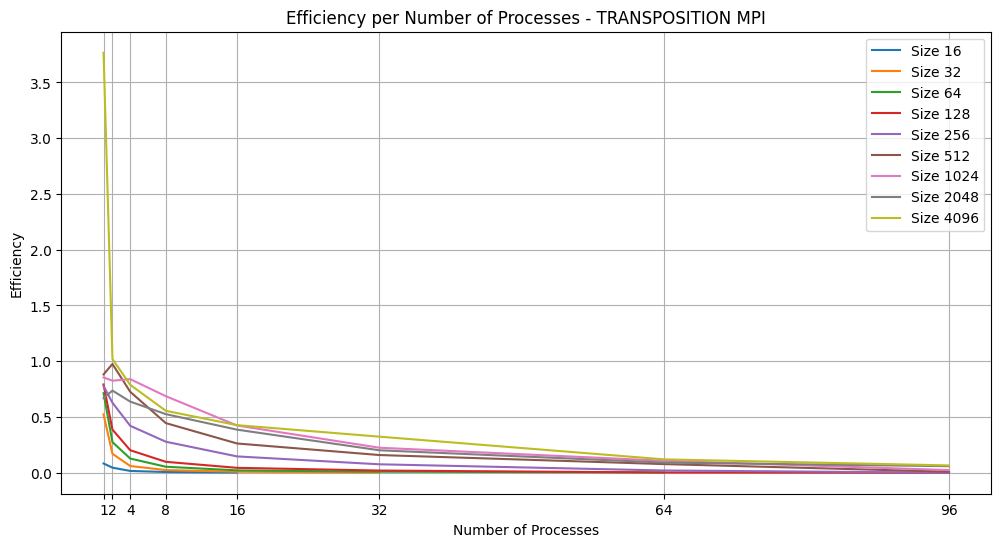

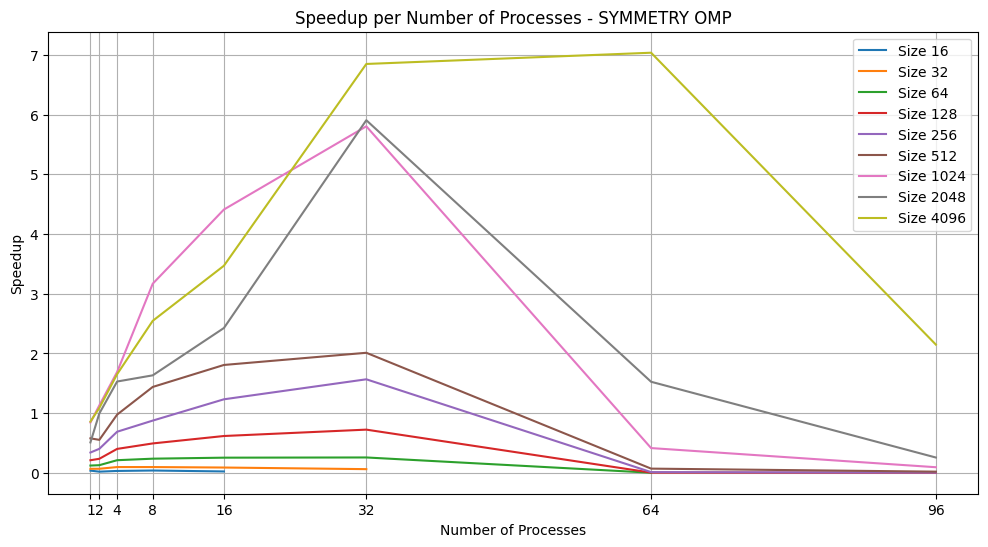

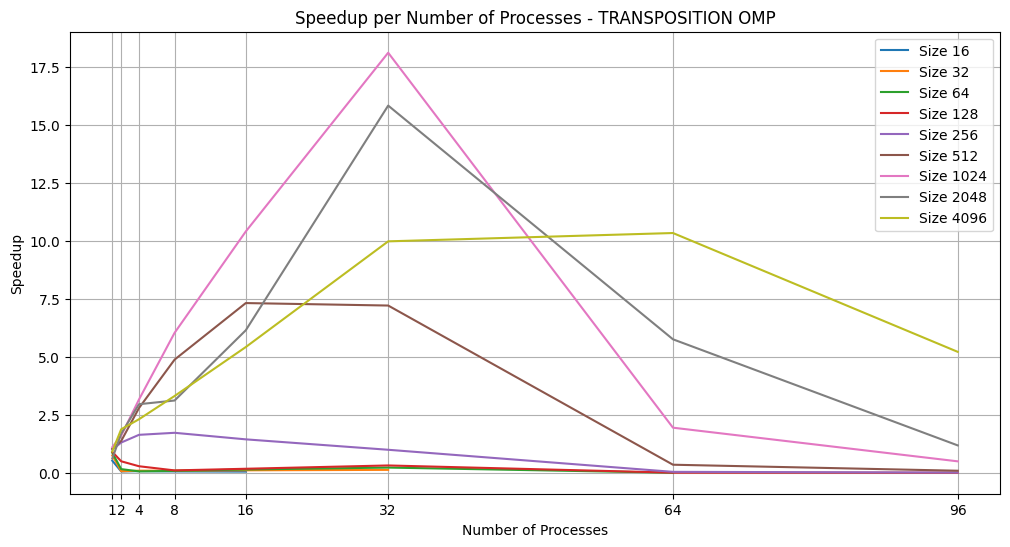

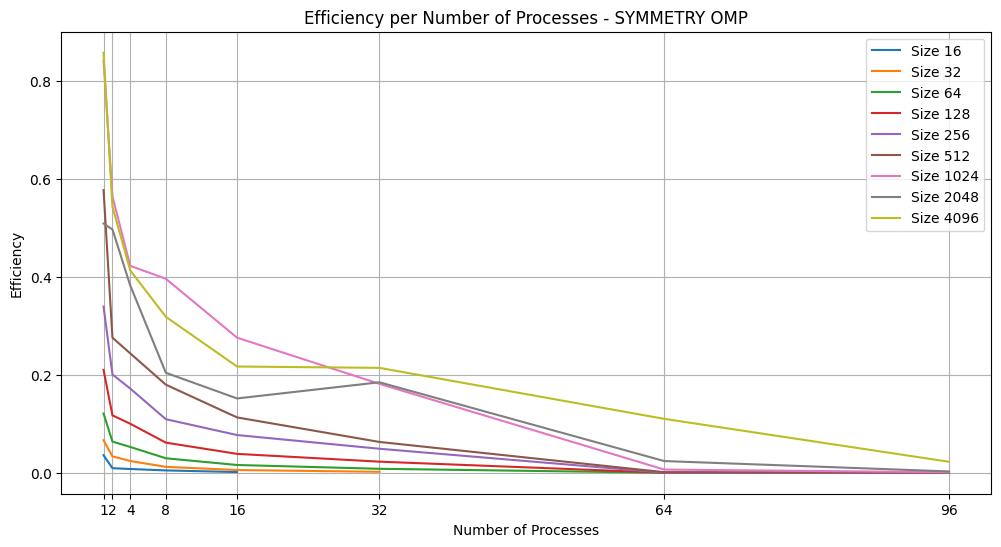

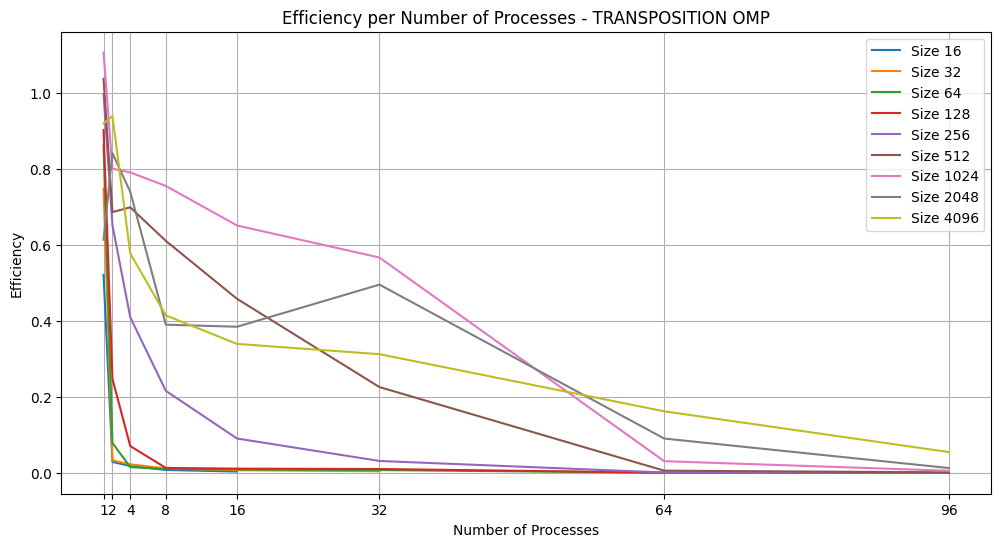

In [383]:
# df_mpi_metrics = calculate_speedup_efficiency(df, "MPI")
plot_speedup_efficiency(calculate_speedup_efficiency(df, "MPI"), "MPI")
plot_speedup_efficiency(calculate_speedup_efficiency(df, "OMP"), "OMP")


In [384]:
# def plot_weak_scaling(df, func):
#     #function that plots execution time over n processors to show weak scaling, matrix size is equal to n processors except for n processors = 96 where matrix size is 128
#     df_weak = df[(df["Function"] == func)]
#     df_weak = df_weak[df_weak["Matrix Size"] == df_weak["Processes"]]
#     df_weak = df_weak[df_weak["Processes"] <= 96]
#     plt.figure(figsize=(12, 6))
#     plt.plot(df_weak["Processes"], df_weak["Efficiency"] * 1e3)
#     plt.xlabel("Number of Processes")
#     plt.ylabel("Efficiency")
#     plt.yscale("log")
#     plt.title(f"Weak Scaling - {func} MPI")
#     plt.grid(True)
#     plt.savefig(f"{output_path}/weak_scaling_{func}_mpi.png")
#     # plt.show()
    

In [385]:
# plot_weak_scaling(df_mpi_metrics, "SYMMETRY")
# plot_weak_scaling(df_mpi_metrics, "TRANSPOSITION")